# NICE for calibration

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.optimizers import Adam, SGD

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot, reliability_diagram, ECE_plot
from flows.nice import AddCouplingLayer, MLP, ReIndex
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator

In [4]:
%matplotlib inline
np.random.seed(2)

## Define NICE flow

In [5]:
input_dim = 3
activation='relu'
hidden_size = [3, 3]

### Coupling functions

In [6]:
m1 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)
m2 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)
m3 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)
m4 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)

Instructions for updating:
Colocations handled automatically by placer.


### Forward flow 

In [7]:
inp = Input(shape=(input_dim,))

x = AddCouplingLayer(m1, mode='even')(inp)
x = ReIndex()(x)
x = AddCouplingLayer(m2, mode='even')(x)
x = ReIndex()(x)
x = AddCouplingLayer(m3, mode='even')(x)
x = ReIndex()(x)
x = AddCouplingLayer(m4, mode='even')(x)
x = ReIndex()(x)

nice_flow = Model(inputs=inp, outputs=x)

### Inverse flow 

In [8]:
inv_inp = Input(shape=(input_dim,))

x = ReIndex()(inv_inp)
x = AddCouplingLayer(m4, mode='even', inverse=True)(x)
x = ReIndex()(x)
x = AddCouplingLayer(m3, mode='even', inverse=True)(x)
x = ReIndex()(x)
x = AddCouplingLayer(m2, mode='even', inverse=True)(x)
x = ReIndex()(x)
x = AddCouplingLayer(m1, mode='even', inverse=True)(x)

inv_nice_flow = Model(inputs=inv_inp, outputs=x)

### Trainable model

In [9]:
# Softmax output layer
y = Activation('softmax')(nice_flow.output)

nice_calibrator = Model(inputs=nice_flow.input, outputs=y)
nice_calibrator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
add_coupling_layer (AddCoupl (None, 3)                 25        
_________________________________________________________________
re_index (ReIndex)           (None, 3)                 0         
_________________________________________________________________
add_coupling_layer_1 (AddCou (None, 3)                 25        
_________________________________________________________________
re_index_1 (ReIndex)         (None, 3)                 0         
_________________________________________________________________
add_coupling_layer_2 (AddCou (None, 3)                 25        
_________________________________________________________________
re_index_2 (ReIndex)         (None, 3)                 0         
__________

## Comparison against other calibration methods

### Generate fake target disitribution and simulated predictions

In [10]:
n_samples = 1500

In [11]:
target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

In [12]:
# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.3

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

snt_logits = 0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset
snt_probs = softmax(snt_logits, axis=1)

nll = neg_log_likelihood(snt_probs, target)
ECE = expected_calibration_error(snt_probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))
print("Expected Calibration Error of the classifier predictions: {:.5f}".format(ECE))

Negative log-likelihood of the classifier predictions: 0.82712
Expected Calibration Error of the classifier predictions: 0.37442


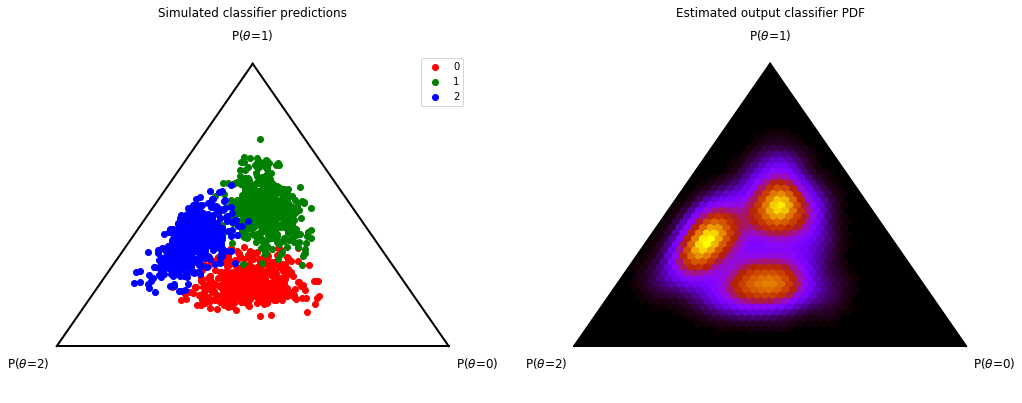

In [13]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(snt_probs, target=target, ax=ax_arr[0], title='Simulated classifier predictions', fontsize=12);
ax_arr[1] = plot_pdf_simplex(snt_probs, ax=ax_arr[1], title='Estimated output classifier PDF', fontsize=12);
plt.show()

### Apply temperature scaling 

In [14]:
# Temp scaling
T = optim_temperature(snt_logits, target)
temp_probs = softmax(snt_logits/T, axis=1)

nll_temp = neg_log_likelihood(temp_probs, target)
ECE_temp = expected_calibration_error(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(nll_temp))
print("Expected Calibration Error after calibration with temp-scaling: {:.3f}".format(ECE_temp))

Negative log-likelihood after calibration with temp-scaling: 0.614
Expected Calibration Error after calibration with temp-scaling: 0.226


### Calibrate with PAV extended to multiclass(normalization)

In [15]:
pav_cal = PAVCalibrator(snt_logits, target)

In [16]:
pav_probs = pav_cal.predict(snt_logits)

nll_pav = neg_log_likelihood(pav_probs, target)
ECE_pav = expected_calibration_error(pav_probs, target)

print("Negative log-likelihood after calibration with PAV: {:.3f}".format(nll_pav))
print("Expected Calibration Error after calibration with PAV: {:.3f}".format(ECE_pav))

Negative log-likelihood after calibration with PAV: 0.488
Expected Calibration Error after calibration with PAV: 0.246


### Calibrate with Multiclass Logistic Regression 

In [17]:
mlr_cal = MLRCalibrator(snt_logits, target)

In [18]:
mlr_probs = mlr_cal.predict(snt_logits)

nll_mlr = neg_log_likelihood(mlr_probs, target)
ECE_mlr = expected_calibration_error(mlr_probs, target)

print("Negative log-likelihood after calibration with mlr: {:.3f}".format(nll_mlr))
print("Expected Calibration Error after calibration with mlr: {:.3f}".format(ECE_mlr))

Negative log-likelihood after calibration with mlr: 0.633
Expected Calibration Error after calibration with mlr: 0.191


### Calibrate with NICE flow

In [19]:
nice_calibrator.compile(optimizer='adam', loss='categorical_crossentropy')

Fit Nice Flow v2

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


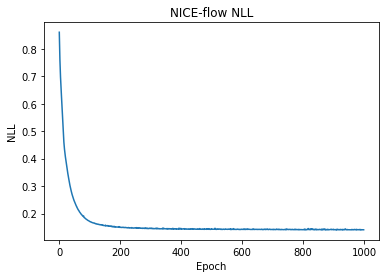

In [20]:
h = nice_calibrator.fit(snt_logits, one_hot, epochs=1000, batch_size=100, verbose=0)

# Plot training NLL
plt.plot(h.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

In [21]:
nice_probs = nice_calibrator.predict(snt_logits, batch_size=100)

nll_nice = neg_log_likelihood(nice_probs, target)
ECE_nice = expected_calibration_error(nice_probs, target)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))
print("Expected Calibration Error after calibration with NICE: {:.3f}".format(ECE_nice))

Negative log-likelihood after calibration with NICE: 0.140
Expected Calibration Error after calibration with NICE: 0.047


### Visualizing results

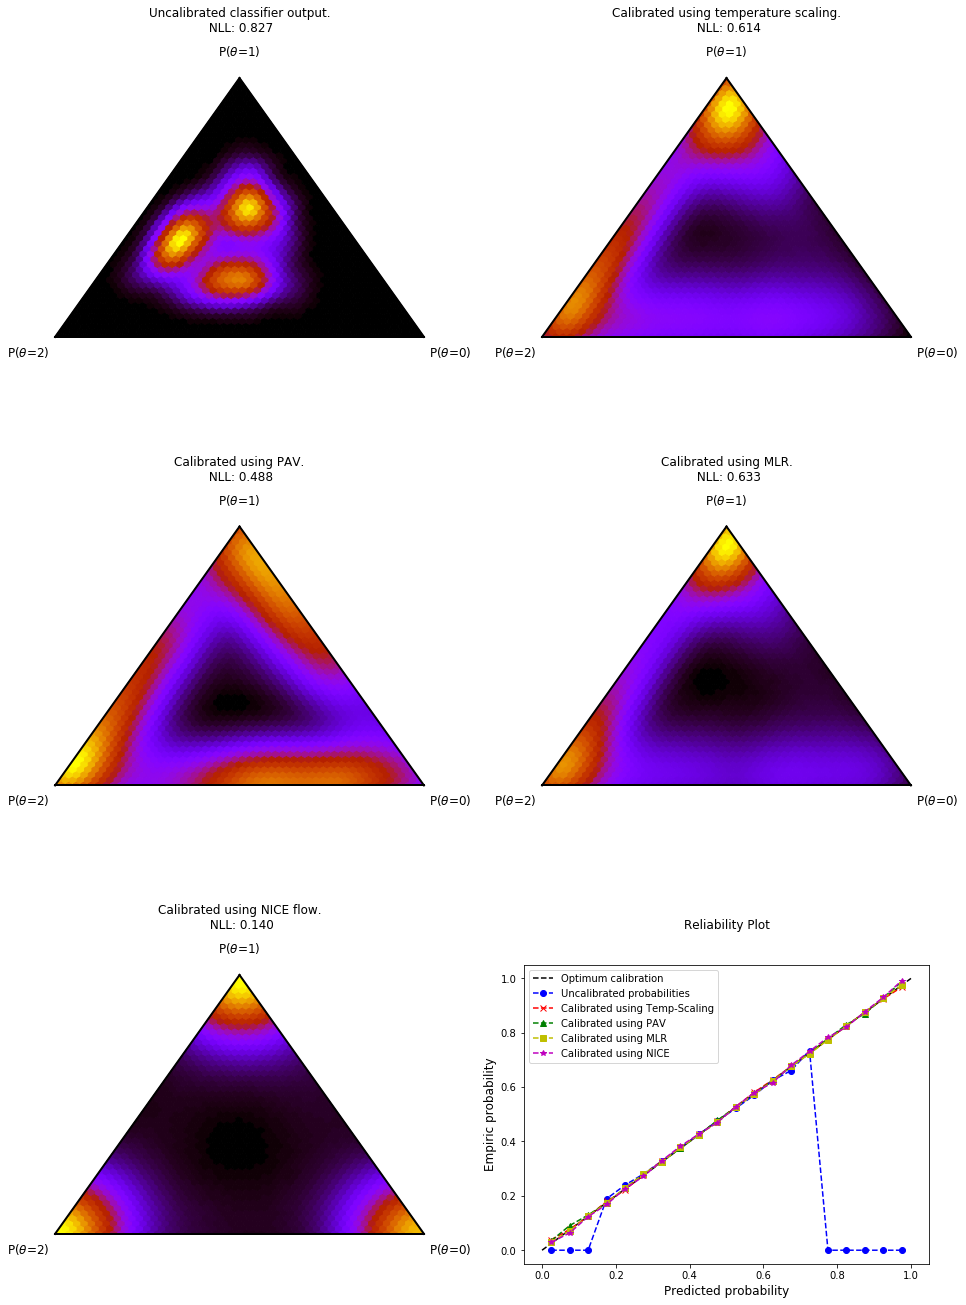

In [22]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 22), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = plot_pdf_simplex(snt_probs, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n NLL: {:.3f}'.format(nll), fontsize=12);
ax_arr[0, 1] = plot_pdf_simplex(temp_probs, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n NLL: {:.3f}'.format(nll_temp), fontsize=12);
ax_arr[1, 0] = plot_pdf_simplex(pav_probs, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n NLL: {:.3f}'.format(nll_pav), fontsize=12);
ax_arr[1, 1] = plot_pdf_simplex(mlr_probs, ax=ax_arr[1, 1],
                             title='Calibrated using MLR.\n NLL: {:.3f}'.format(nll_mlr), fontsize=12);
ax_arr[2, 0] = plot_pdf_simplex(nice_probs, ax=ax_arr[2, 0],
                             title='Calibrated using NICE flow.\n NLL: {:.3f}'.format(nll_nice), fontsize=12);

ax_arr[2, 1] = reliability_plot([snt_probs, temp_probs, pav_probs, mlr_probs, nice_probs], target, ax=ax_arr[2, 1],
                                labels=['Uncalibrated probabilities', 'Calibrated using Temp-Scaling',
                                        'Calibrated using PAV', 'Calibrated using MLR', 'Calibrated using NICE']);

plt.show()

Reliability diagrams:

[[0.29467497 0.46077216 0.24455287]
 [0.48164878 0.18301507 0.33533615]
 [0.19206335 0.59420685 0.2137298 ]
 [0.33777621 0.16767941 0.49454438]
 [0.40421653 0.25291942 0.34286406]
 [0.10566396 0.44539856 0.44893748]
 [0.34367613 0.16431179 0.49201208]
 [0.2560982  0.52881316 0.21508864]
 [0.32389661 0.30763612 0.36846727]
 [0.34178036 0.25526263 0.40295701]]
[1 0 1 0 0 2 0 1 0 0]
[ True  True  True False  True  True False  True False False]
[[0.14196856 0.78858978 0.06944166]
 [0.78504491 0.01918665 0.19576844]
 [0.01272265 0.96810704 0.01917031]
 [0.18572858 0.01265544 0.80161598]
 [0.58913668 0.09753517 0.31332815]
 [0.00197193 0.4914407  0.50658738]
 [0.1992449  0.0117529  0.78900221]
 [0.05666056 0.9143271  0.02901234]
 [0.28898083 0.23717546 0.47384371]
 [0.31181655 0.10178795 0.5863955 ]]
[1 0 1 0 0 2 0 1 0 0]
[ True  True  True False  True  True False  True False False]
[[0.33678756 0.66321244 0.        ]
 [0.80740741 0.         0.19259259]
 [0.00704225 0.99295775 0.        ]
 [

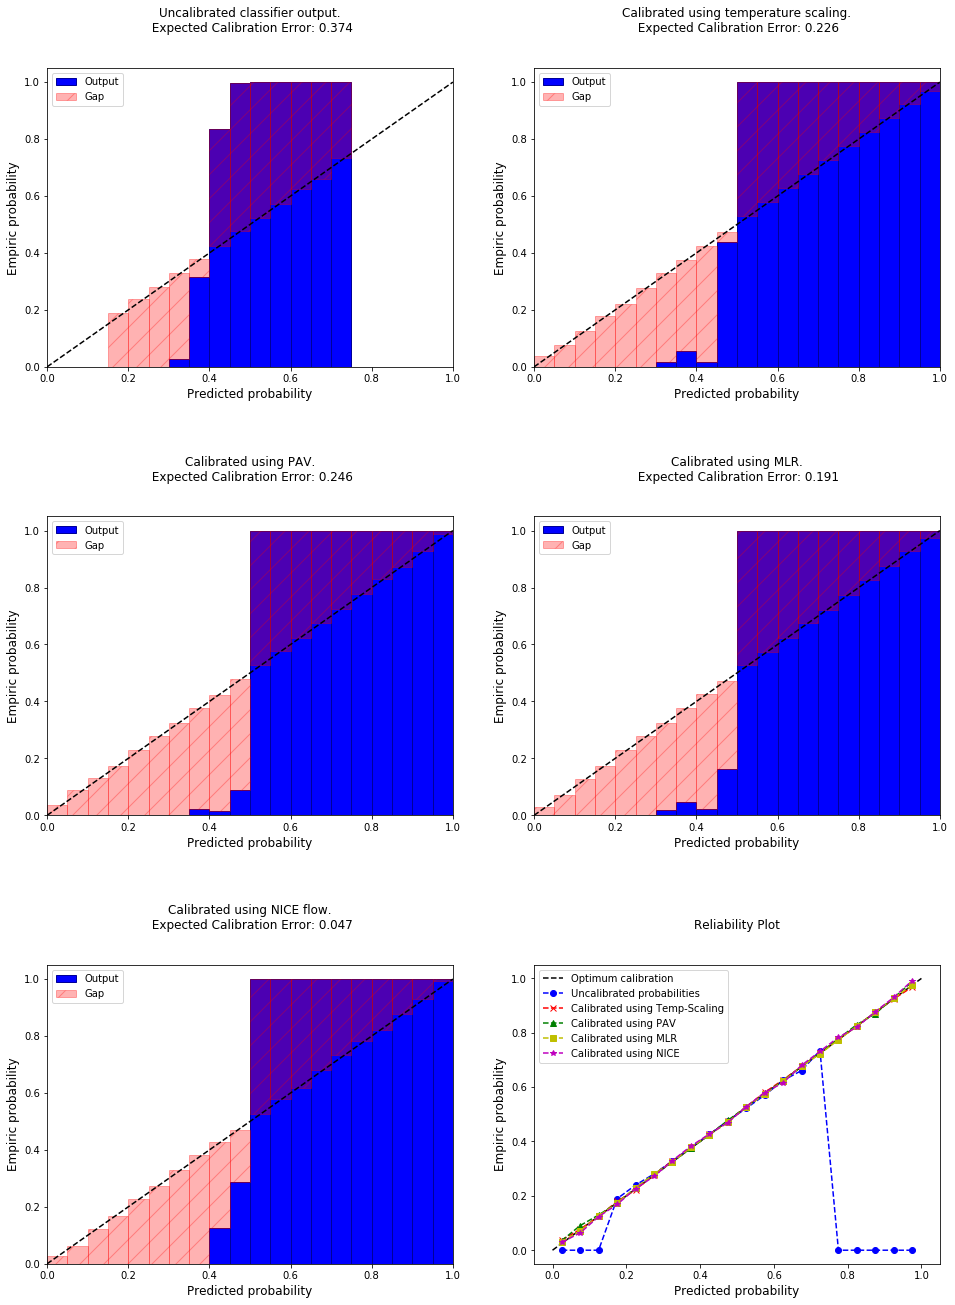

In [23]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 22), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(snt_probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n Expected Calibration Error: {:.3f}'.format(ECE), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n Expected Calibration Error: {:.3f}'.format(ECE_temp), fontsize=12);
ax_arr[1, 0] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n Expected Calibration Error: {:.3f}'.format(ECE_pav), fontsize=12);
ax_arr[1, 1] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using MLR.\n Expected Calibration Error: {:.3f}'.format(ECE_mlr), fontsize=12);
ax_arr[2, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using NICE flow.\n Expected Calibration Error: {:.3f}'.format(ECE_nice), fontsize=12);

ax_arr[2, 1] = reliability_plot([snt_probs, temp_probs, pav_probs, mlr_probs, nice_probs], target, ax=ax_arr[2, 1],
                                labels=['Uncalibrated probabilities', 'Calibrated using Temp-Scaling',
                                        'Calibrated using PAV', 'Calibrated using MLR', 'Calibrated using NICE']);

plt.show()

### ECE plots:

Define the detection problem, we have the hypothesis: $H_{t} \equiv P(\theta=\theta_0)$ and the hypothesis space is defined over $\{H_{t}, \neg H_{t}\}$, where $\neg$ is the negation operator. We evaluate for all possible values of $\theta_0 = \{0, 1, 2\}$

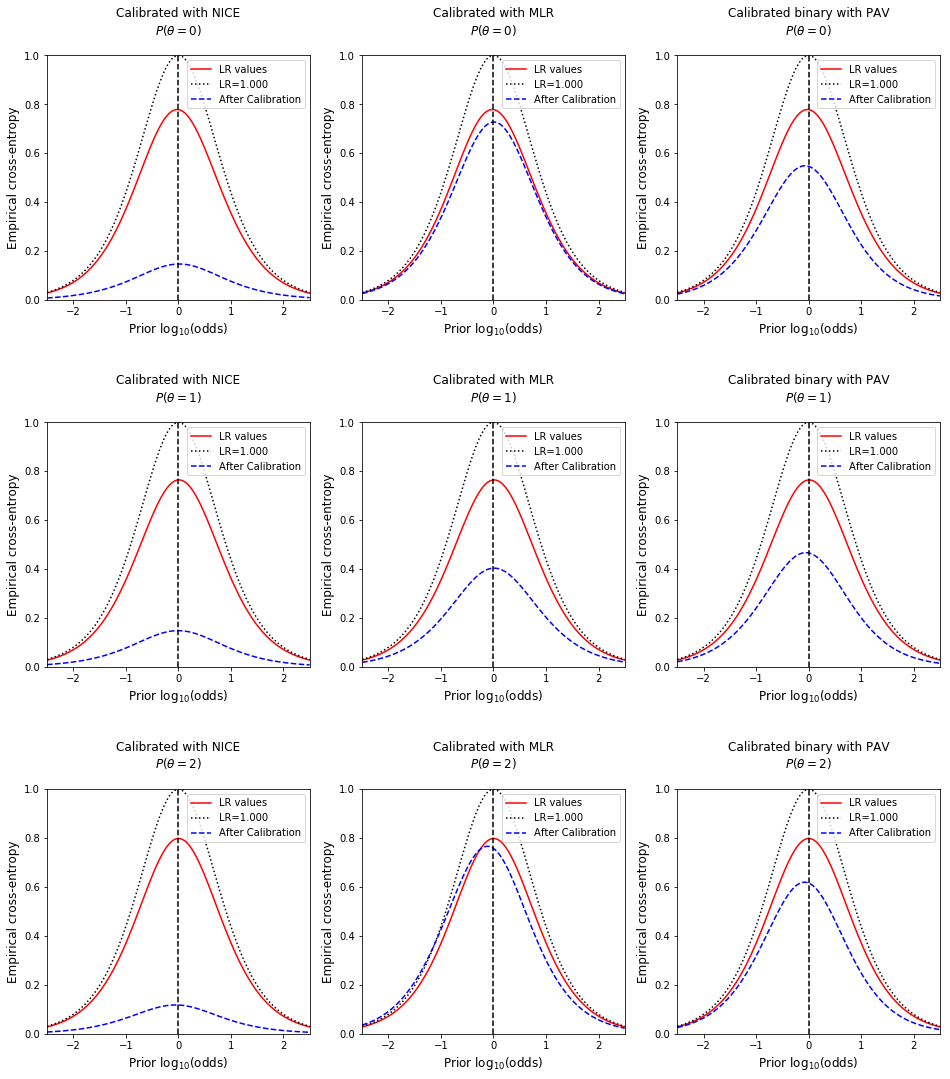

In [24]:
LRs = detection_log_likelihood_ratios(snt_logits, np.zeros(3) + 1/3.)
nice_logits = nice_flow.predict(snt_logits)
LRs_cal = detection_log_likelihood_ratios(nice_logits, np.zeros(3) + 1/3.)
LRs_cal_MLR = detection_log_likelihood_ratios(np.log(mlr_probs), np.zeros(3) + 1/3.)

fig, ax_arr = plt.subplots(3, 3, figsize=(16, 18), gridspec_kw={'hspace': 0.5})


# H_t = P(theta=0)
pav_cal = IsotonicRegression(y_min=0, y_max=1).fit_transform(snt_probs[:, 0], target==0) 
pav_cal = pav_cal/(1. - pav_cal + 1e-7) + 1e-7

ax_arr[0, 0] = ECE_plot(np.exp(LRs[:, 0]), target==0, cal_ratios=np.exp(LRs_cal[:, 0]), ax=ax_arr[0, 0], title='Calibrated with NICE\n$P(\\theta=0)$')
ax_arr[0, 1] = ECE_plot(np.exp(LRs[:, 0]), target==0, cal_ratios=np.exp(LRs_cal_MLR[:, 0]), ax=ax_arr[0, 1], title='Calibrated with MLR\n$P(\\theta=0)$')
ax_arr[0, 2] = ECE_plot(np.exp(LRs[:, 0]), target==0, cal_ratios=pav_cal, ax=ax_arr[0, 2], title='Calibrated binary with PAV\n$P(\\theta=0)$')

# H_t = P(theta=1)
pav_cal = IsotonicRegression(y_min=0, y_max=1).fit_transform(snt_probs[:, 1], target==1) 
pav_cal = pav_cal/(1. - pav_cal + 1e-7) + 1e-7

ax_arr[1, 0] = ECE_plot(np.exp(LRs[:, 1]), target==1, cal_ratios=np.exp(LRs_cal[:, 1]), ax=ax_arr[1, 0], title='Calibrated with NICE\n$P(\\theta=1)$')
ax_arr[1, 1] = ECE_plot(np.exp(LRs[:, 1]), target==1, cal_ratios=np.exp(LRs_cal_MLR[:, 1]), ax=ax_arr[1, 1], title='Calibrated with MLR\n$P(\\theta=1)$')
ax_arr[1, 2] = ECE_plot(np.exp(LRs[:, 1]), target==1, cal_ratios=pav_cal, ax=ax_arr[1, 2], title='Calibrated binary with PAV\n$P(\\theta=1)$')

# H_t = P(theta=2)
pav_cal = IsotonicRegression(y_min=0, y_max=1).fit_transform(snt_probs[:, 2], target==2) 
pav_cal = pav_cal/(1. - pav_cal + 1e-7) + 1e-7

ax_arr[2, 0] = ECE_plot(np.exp(LRs[:, 2]), target==2, cal_ratios=np.exp(LRs_cal[:, 2]), ax=ax_arr[2, 0], title='Calibrated with NICE\n$P(\\theta=2)$')
ax_arr[2, 1] = ECE_plot(np.exp(LRs[:, 2]), target==2, cal_ratios=np.exp(LRs_cal_MLR[:, 2]), ax=ax_arr[2, 1], title='Calibrated with MLR\n$P(\\theta=2)$')
ax_arr[2, 2] = ECE_plot(np.exp(LRs[:, 2]), target==2, cal_ratios=pav_cal, ax=ax_arr[2, 2], title='Calibrated binary with PAV\n$P(\\theta=2)$')


plt.show()

## Check that NICE flow is an invertible transformation

In [25]:
# Forward flow
nice_logits = nice_flow.predict(snt_logits, batch_size=100)
# Inverse flow
recons_logits = inv_nice_flow.predict(nice_logits, batch_size=100)

recons_rmse = np.sqrt(np.mean(np.square(snt_logits-recons_logits)))
print("Root mean square reconstrucction error is: {:.3E}".format(recons_rmse))

Root mean square reconstrucction error is: 1.302E-06


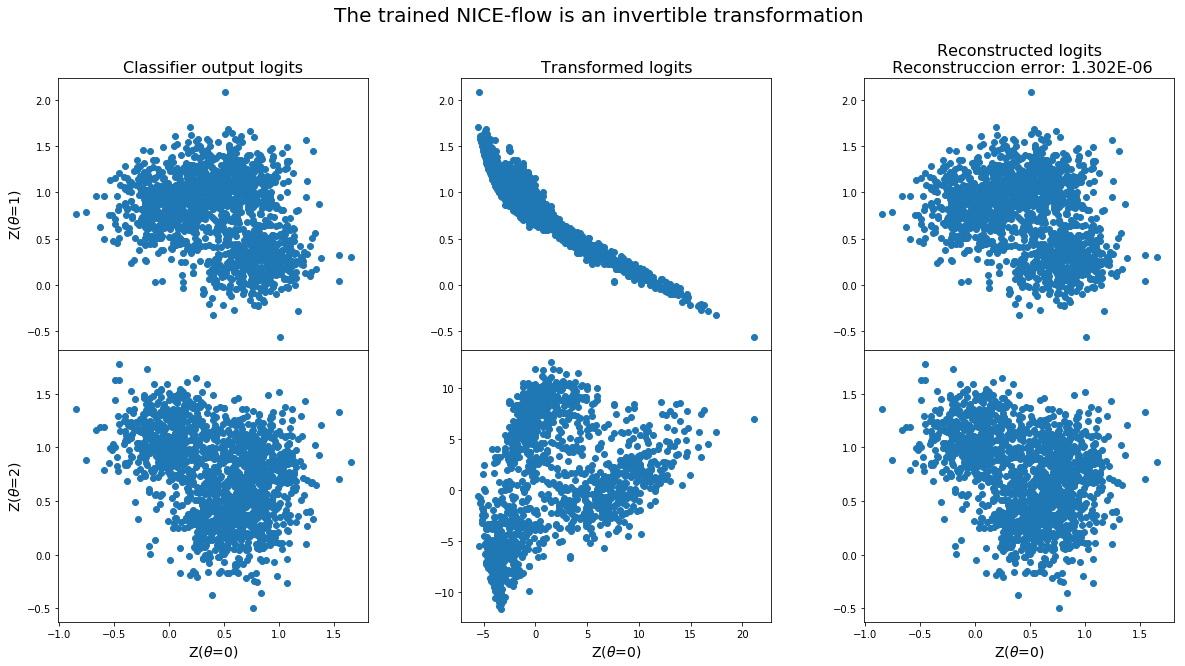

In [26]:
fig, ax_arr = plt.subplots(2, 3, sharex='col', figsize=(20, 10), gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('The trained NICE-flow is an invertible transformation', fontsize=20)

ax_arr[0, 0].scatter(snt_logits[:, 0], snt_logits[:, 1]);
ax_arr[1, 0].scatter(snt_logits[:, 0], snt_logits[:, 2]);

ax_arr[0, 1].scatter(nice_logits[:, 0], nice_logits[:, 1]);
ax_arr[1, 1].scatter(nice_logits[:, 0], nice_logits[:, 2]);

ax_arr[0, 2].scatter(recons_logits[:, 0], recons_logits[:, 1]);
ax_arr[1, 2].scatter(recons_logits[:, 0], recons_logits[:, 2]);

titles = [
    'Classifier output logits', 
    'Transformed logits', 
    'Reconstructed logits\n Reconstruccion error: {:.3E}'.format(recons_rmse)
]
y_labels = ['Z($\\theta$=1)', 'Z($\\theta$=2)']

for ax, title in zip(ax_arr[0], titles):
    ax.set_title(title, fontsize=16)

for ax in ax_arr[-1]:
    ax.set_xlabel('Z($\\theta$=0)', fontsize=14)

for ax, label in zip(ax_arr[:,0], y_labels):
    ax.set_ylabel(label, fontsize=14)

# fig.tight_layout()
plt.show()